In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
tf.config.list_physical_devices('GPU')

2024-10-14 11:14:00.735192: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 11:14:00.763688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 11:14:00.763718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 11:14:00.764507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 11:14:00.769678: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import urllib3
urllib3.disable_warnings()

setattr(tfds.image_classification.cats_vs_dogs, '_URL', "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(ds_trainset, ds_testset), ds_info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], as_supervised=True, shuffle_files=True, with_info=True)

2024-10-14 11:14:02.575367: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


/usr/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]2024-10-14 11:22:01.884317: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-14 11:22:01.884397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-14 11:22:01.884419: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without N

Dataset cats_vs_dogs downloaded and prepared to /home/chio4696/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [4]:
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1, is_50=False, is_plain=False):
    x = input_layer
    identity = x

    for cnn_num in range(num_cnn if not is_50 else 1):
        x = keras.layers.Conv2D(
            filters=channel if not is_50 else channel * (1 if cnn_num < 2 else 4),
            kernel_size=(1, 1) if is_50 and cnn_num != 1 else (3, 3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)

    if not is_plain:
        identity_channel = identity.shape.as_list()[-1]
        identity = keras.layers.Conv2D(
            channel if identity_channel != channel else identity_channel, 
            kernel_size=(1, 1), 
            strides=(1, 1), 
            padding="same"
        )(identity) if identity_channel != channel else identity
        x = keras.layers.Add()([x, identity])

    if identity.shape[1] != 1:
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2), strides=2, name=f'block{block_num}_pooling'
        )(x)

    return x

In [5]:
def build_resnet(input_shape=(32, 32, 3), num_cnn_list=[3, 4, 6, 3], channel_list=[64, 128, 256, 512], 
                 num_classes=10, is_50=False, is_plain=False):

    assert len(num_cnn_list) == len(channel_list)

    if is_50:
        num_cnn_list, channel_list = [3, 4, 6, 3], [64, 128, 256, 512]

    input_layer = keras.layers.Input(shape=input_shape)

    output = keras.layers.Conv2D(64, kernel_size=(2, 2), strides=2, padding='valid')(input_layer)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(output)

    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(output, num_cnn=num_cnn, channel=channel, block_num=i, is_50=is_50, is_plain=is_plain)

    output = keras.layers.AveragePooling2D(padding='same')(output)
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(512, activation='relu')(output)
    
    output = keras.layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(output)

    return keras.Model(inputs=input_layer, outputs=output)

In [6]:
resnet_34 = build_resnet(input_shape=(224, 224, 3))
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         832       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['batch_normalization[0][0

In [7]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 112, 112, 64)         832       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_17 (Ba  (None, 112, 112, 64)         256       ['conv2d_4[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)           0         ['batch_normalization_17

In [8]:
plainnet = build_resnet(input_shape=(224, 224, 3), is_plain=True)
plainnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      832       
                                                                 
 batch_normalization_22 (Ba  (None, 112, 112, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 block0_conv0 (Conv2D)       (None, 56, 56, 64)        36928     
                                                                 
 batch_normalization_23 (Ba  (None, 56, 56, 64)        256 

In [9]:
BATCH_SIZE = 64
EPOCH = 30

ds_train = ds_trainset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_testset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30


2024-10-14 11:23:03.758152: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-10-14 11:23:06.672934: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efeab59b720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-14 11:23:06.672968: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
I0000 00:00:1728872586.736477   18812 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


291/291 [==============================] - 68s 194ms/step - loss: 0.8244 - accuracy: 0.6132 - val_loss: 1.0878 - val_accuracy: 0.5148
Epoch 2/30
  2/291 [..............................] - ETA: 46s - loss: 0.8492 - accuracy: 0.6094

KeyboardInterrupt: 

In [95]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
291/291 [==============================] - 92s 295ms/step - loss: 1.6264 - accuracy: 0.5796 - val_loss: 0.8220 - val_accuracy: 0.5733
Epoch 2/30
291/291 [==============================] - 84s 289ms/step - loss: 1.0670 - accuracy: 0.6328 - val_loss: 1.0368 - val_accuracy: 0.5935
Epoch 3/30
291/291 [==============================] - 86s 295ms/step - loss: 0.8149 - accuracy: 0.6630 - val_loss: 0.7370 - val_accuracy: 0.6715
Epoch 4/30
291/291 [==============================] - 84s 287ms/step - loss: 0.6589 - accuracy: 0.7030 - val_loss: 0.9861 - val_accuracy: 0.6083
Epoch 5/30
291/291 [==============================] - 85s 294ms/step - loss: 0.5491 - accuracy: 0.7387 - val_loss: 0.9020 - val_accuracy: 0.6154
Epoch 6/30
291/291 [==============================] - 84s 288ms/step - loss: 0.4776 - accuracy: 0.7738 - val_loss: 0.6492 - val_accuracy: 0.6930
Epoch 7/30
291/291 [==============================] - 86s 295ms/step - loss: 0.4267 - accuracy: 0.8001 - val_loss: 0.5212 - val_ac

In [96]:
plainnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_pl = plainnet.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
291/291 [==============================] - 87s 281ms/step - loss: 1.7306 - accuracy: 0.5671 - val_loss: 0.8008 - val_accuracy: 0.5666
Epoch 2/30
291/291 [==============================] - 83s 287ms/step - loss: 1.0808 - accuracy: 0.6236 - val_loss: 0.7136 - val_accuracy: 0.6720
Epoch 3/30
291/291 [==============================] - 81s 279ms/step - loss: 0.7982 - accuracy: 0.6556 - val_loss: 0.7676 - val_accuracy: 0.6457
Epoch 4/30
291/291 [==============================] - 82s 280ms/step - loss: 0.6165 - accuracy: 0.7056 - val_loss: 0.7078 - val_accuracy: 0.6638
Epoch 5/30
291/291 [==============================] - 83s 284ms/step - loss: 0.5164 - accuracy: 0.7515 - val_loss: 0.6614 - val_accuracy: 0.6855
Epoch 6/30
291/291 [==============================] - 83s 287ms/step - loss: 0.4505 - accuracy: 0.7877 - val_loss: 0.5500 - val_accuracy: 0.7358
Epoch 7/30
291/291 [==============================] - 81s 279ms/step - loss: 0.4073 - accuracy: 0.8125 - val_loss: 0.5336 - val_ac

In [97]:
plainnet50 = build_resnet(input_shape=(224, 224, 3), is_50=True, is_plain=True)
plainnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_pl50 = plainnet50.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
291/291 [==============================] - 87s 280ms/step - loss: 1.5370 - accuracy: 0.5724 - val_loss: 0.7185 - val_accuracy: 0.5974
Epoch 2/30
291/291 [==============================] - 83s 285ms/step - loss: 0.9586 - accuracy: 0.6239 - val_loss: 0.6931 - val_accuracy: 0.6531
Epoch 3/30
291/291 [==============================] - 81s 279ms/step - loss: 0.7008 - accuracy: 0.6779 - val_loss: 0.7951 - val_accuracy: 0.6460
Epoch 4/30
291/291 [==============================] - 83s 286ms/step - loss: 0.5876 - accuracy: 0.7156 - val_loss: 0.8689 - val_accuracy: 0.6019
Epoch 5/30
291/291 [==============================] - 81s 279ms/step - loss: 0.5085 - accuracy: 0.7564 - val_loss: 0.6329 - val_accuracy: 0.7003
Epoch 6/30
291/291 [==============================] - 83s 286ms/step - loss: 0.4637 - accuracy: 0.7778 - val_loss: 0.5667 - val_accuracy: 0.7339
Epoch 7/30
291/291 [==============================] - 82s 280ms/step - loss: 0.4146 - accuracy: 0.8059 - val_loss: 0.8302 - val_ac

In [141]:
resnet_34.save("resnet_34")
resnet_50.save("resnet_50")
plainnet.save("plainnet_34")
plainnet50.save("plainnet_50")

import pandas as pd

df = pd.DataFrame(history_34.history) 
hist_json_file = 'history_34.json' 
with open(hist_json_file, mode='w') as f:
    df.to_json(f)
df = pd.DataFrame(history_50.history) 
hist_json_file = 'history_50.json' 
with open(hist_json_file, mode='w') as f:
    df.to_json(f)
df = pd.DataFrame(history_pl.history) 
hist_json_file = 'history_pl.json' 
with open(hist_json_file, mode='w') as f:
    df.to_json(f)
df = pd.DataFrame(history_pl50.history) 
hist_json_file = 'history_pl50.json' 
with open(hist_json_file, mode='w') as f:
    df.to_json(f)

INFO:tensorflow:Assets written to: resnet_34/assets


INFO:tensorflow:Assets written to: resnet_34/assets


INFO:tensorflow:Assets written to: resnet_50/assets


INFO:tensorflow:Assets written to: resnet_50/assets


INFO:tensorflow:Assets written to: plainnet_34/assets


INFO:tensorflow:Assets written to: plainnet_34/assets


INFO:tensorflow:Assets written to: plainnet_50/assets


INFO:tensorflow:Assets written to: plainnet_50/assets


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

history_34 = 'history_34.json'
df = pd.read_json(history_34)
history_34 = df.to_dict(orient='list')

history_50 = 'history_50.json'
df = pd.read_json(history_50)
history_50 = df.to_dict(orient='list')

history_pl = 'history_pl.json'
df = pd.read_json(history_pl)
history_pl = df.to_dict(orient='list')

history_pl50 = 'history_pl50.json'
df = pd.read_json(history_pl50)
history_pl50 = df.to_dict(orient='list')

In [28]:
history_pl50

{'loss': [1.5369548798000001,
  0.9586054087,
  0.7007906437,
  0.5876208544,
  0.5085469484,
  0.4636610746,
  0.4145954847,
  0.3618072867,
  0.30784776810000003,
  0.26457250120000003,
  0.20504710080000002,
  0.1621890664,
  0.1257728338,
  0.0921016932,
  0.0709876046,
  0.0567610152,
  0.0384917483,
  0.0358355828,
  0.0262887422,
  0.025571890200000003,
  0.0258145146,
  0.0194351114,
  0.0194514114,
  0.0135123879,
  0.013165585700000001,
  0.0096024526,
  0.0074478323,
  0.006345085800000001,
  0.0053044474000000005,
  0.0019202959000000001],
 'accuracy': [0.5724341869,
  0.6239118576,
  0.6778613925,
  0.7155830264,
  0.7563675642000001,
  0.7777538896,
  0.8059108257,
  0.8383127451,
  0.864212811,
  0.8866201043,
  0.9123589396,
  0.9326705933,
  0.9512627721,
  0.9645889401000001,
  0.9748522043000001,
  0.9799569845,
  0.9874798656,
  0.9872649312,
  0.9925846457,
  0.9909725785000001,
  0.9908651114,
  0.9936593175,
  0.9933369160000001,
  0.9955400229,
  0.99564749,
  0

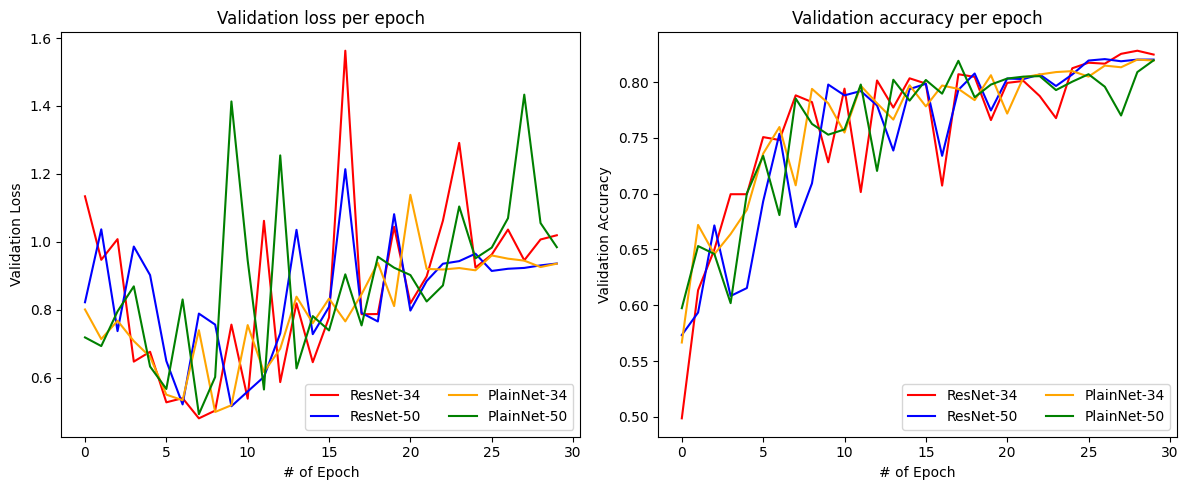

In [29]:
epochs = np.arange(len(history_34['val_loss']))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_34['val_loss'], label='ResNet-34', color='red')
plt.plot(epochs, history_50['val_loss'], label='ResNet-50', color='blue')
plt.plot(epochs, history_pl['val_loss'], label='PlainNet-34', color='orange')
plt.plot(epochs, history_pl50['val_loss'], label='PlainNet-50', color='green')
plt.title('Validation loss per epoch')
plt.xlabel('# of Epoch')
plt.ylabel('Validation Loss')
plt.legend(['ResNet-34', 'ResNet-50', 'PlainNet-34', 'PlainNet-50'], loc='lower right', ncol=2)

plt.subplot(1, 2, 2)
plt.plot(epochs, history_34['val_accuracy'], label='ResNet-34', color='red')
plt.plot(epochs, history_50['val_accuracy'], label='ResNet-50', color='blue')
plt.plot(epochs, history_pl['val_accuracy'], label='PlainNet-34', color='orange')
plt.plot(epochs, history_pl50['val_accuracy'], label='PlainNet-50', color='green')
plt.title('Validation accuracy per epoch')
plt.xlabel('# of Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['ResNet-34', 'ResNet-50', 'PlainNet-34', 'PlainNet-50'], loc='lower right', ncol=2)

plt.tight_layout()
plt.show()

In [38]:
def moving_average(y, window_size):
    return np.convolve(y, np.ones(window_size)/window_size, mode='valid')

def smooth_data(x, y, window_size=5):
    x_smooth = x[:len(moving_average(y, window_size))]
    y_smooth = moving_average(y, window_size)
    return x_smooth, y_smooth

epochs_smooth, val_loss_34_smooth = smooth_data(epochs, np.array(history_34['val_loss']), window_size=5)
_, val_loss_50_smooth = smooth_data(epochs, np.array(history_50['val_loss']), window_size=5)
_, val_loss_pl_smooth = smooth_data(epochs, np.array(history_pl['val_loss']), window_size=5)
_, val_loss_pl50_smooth = smooth_data(epochs, np.array(history_pl50['val_loss']), window_size=5)

epochs_smooth, val_acc_34_smooth = smooth_data(epochs, np.array(history_34['val_accuracy']), window_size=5)
_, val_acc_50_smooth = smooth_data(epochs, np.array(history_50['val_accuracy']), window_size=5)
_, val_acc_pl_smooth = smooth_data(epochs, np.array(history_pl['val_accuracy']), window_size=5)
_, val_acc_pl50_smooth = smooth_data(epochs, np.array(history_pl50['val_accuracy']), window_size=5)

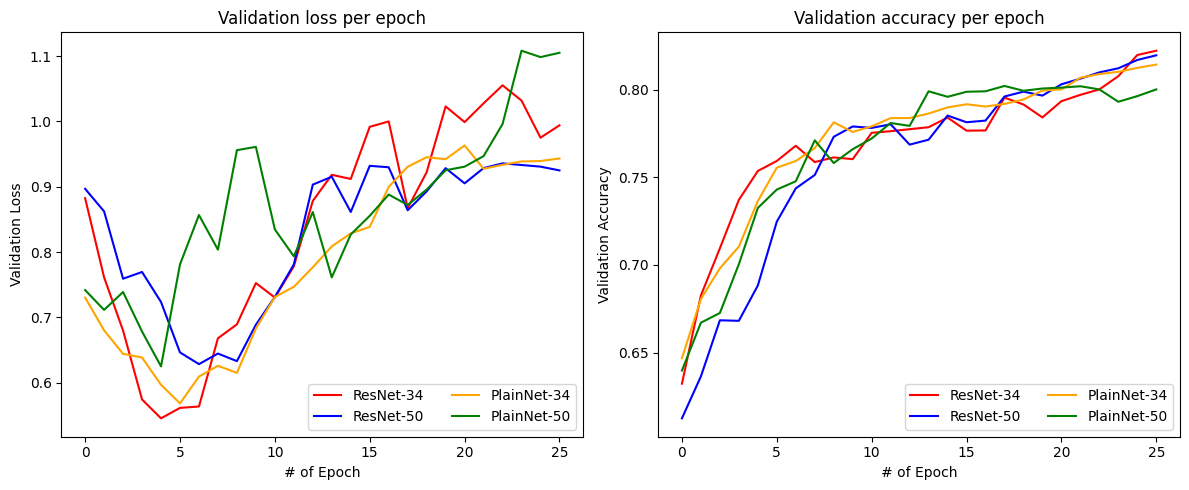

In [39]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_smooth, val_loss_34_smooth, label='ResNet-34', color='red')
plt.plot(epochs_smooth, val_loss_50_smooth, label='ResNet-50', color='blue')
plt.plot(epochs_smooth, val_loss_pl_smooth, label='PlainNet-34', color='orange')
plt.plot(epochs_smooth, val_loss_pl50_smooth, label='PlainNet-50', color='green')
plt.title('Validation loss per epoch')
plt.xlabel('# of Epoch')
plt.ylabel('Validation Loss')
plt.legend(['ResNet-34', 'ResNet-50', 'PlainNet-34', 'PlainNet-50'], loc='lower right', ncol=2)

plt.subplot(1, 2, 2)
plt.plot(epochs_smooth, val_acc_34_smooth, label='ResNet-34', color='red')
plt.plot(epochs_smooth, val_acc_50_smooth, label='ResNet-50', color='blue')
plt.plot(epochs_smooth, val_acc_pl_smooth, label='PlainNet-34', color='orange')
plt.plot(epochs_smooth, val_acc_pl50_smooth, label='PlainNet-50', color='green')
plt.title('Validation accuracy per epoch')
plt.xlabel('# of Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['ResNet-34', 'ResNet-50', 'PlainNet-34', 'PlainNet-50'], loc='lower right', ncol=2)

plt.tight_layout()
plt.show()